# Doing Bayesian Data Analysis - Chapter 6

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as pn

%matplotlib inline
plt.rcParams.update({'font.size': 18})

## Helper functions

In [6]:
"""
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

import numpy as np

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

In [7]:
def plot_chart(df, x, y, title=None):
    ch = (
        pn.ggplot(df, pn.aes(x, y)) +
        pn.geom_line(size=1., color="blue")+
        pn.scale_y_continuous(limits=[0, y.max()*1.2])
    ) 
    
    if title:
        ch += pn.labs(x=title[0], y=title[1], title=title[2])
    
    return ch        

In [80]:
def bern_grid(theta, p_theta, data, credib=.95):
    """
    Bayesian updating for Bernoulli likelihood and prior specified on a grid.
    Input arguments:
     theta is a vector of theta values, all between 0 and 1.
     p_theta is a vector of corresponding probability _masses_.
     data is a vector of 1's and 0's, where 1 corresponds to a and 0 to b.
     credib is the probability mass of the credible interval, default is 0.95.
    Output:
     p_theta_given_data is a vector of posterior probability masses over theta.
     Also creates a three-panel graph of prior, likelihood, and posterior
     probability masses with credible interval.
    Example of use:
     Create vector of theta values.
     bin_width = 1/1000 
     theta_grid = np.arange(0, 1+bin_width, bin_width)
     Specify probability mass at each theta value.
     > rel_prob = np.minimum(theta_grid, 1-theta_grid) relative prob at each theta
     > prior = rel_prob / sum(rel_prob) probability mass at each theta
     Specify the data vector.
     data_vec = np.repeat([1, 0], [11, 3])  # 3 heads, 1 tail
     Call the function.
     > posterior = bern_grid( theta=theta_grid , p_theta=prior , data=data_vec )
    """
    
    # Create summary values of data
    z = sum(data[data == 1])  # number of 1's in data
    N = len(data)  # number of flips in data
    # Compute the likelihood of the data for each value of theta.
    p_data_given_theta = theta**z * (1 - theta)**(N - z)
    # Compute the evidence and the posterior.
    p_data = sum(p_data_given_theta * p_theta)
    p_theta_given_data = p_data_given_theta * p_theta / p_data
    
    mean_theta = sum(theta * p_theta)  # mean of prior, for plotting
    mean_theta_given_data = sum(theta * p_theta_given_data)
    
    # Determine the limits of the highest density interval
    x = np.random.choice(theta, size=5000, replace=True, p=p_theta_given_data)
    intervals = hpd(x, alpha=1-credib)

    df = pd.DataFrame({"theta":theta, 
                      "p_theta":p_theta,
                      "p_theta_given_data":p_theta_given_data, 
                      "p_data_given_theta":p_data_given_theta})

    pn.options.figure_size = (6,4)

    # Plot prior
    if mean_theta > 0.5:
        xloc = df["theta"].min()+0.2        
    else:
        xloc = df["theta"].max()*0.8

    prior = plot_chart(df, theta, p_theta, title=[r'$\theta$', r'$P(\theta)$', "Prior"])
    prior += pn.annotate("text", x=xloc, y=df["p_theta"].max()*1.1, 
                         label=r"E($\theta$)={:5.2f}".format(mean_theta))
    print(prior)
    
    # Plot likelihood
    liklihood = plot_chart(df, theta, p_data_given_theta,
                          title=[r'$\theta$', r'$P(x|\theta)$', "Liklihood"])
    liklihood += pn.annotate("text", x=xloc, y=df["p_data_given_theta"].max()*1.1, 
                             label="data: z={}, N={}".format(z, N))
    print(liklihood)
    
    # Plot posterior
    if mean_theta_given_data > 0.5:
        xloc = df["theta"].min()+0.2
    else:
        xloc = df["theta"].max()*0.8
        
    posterior = plot_chart(df, theta, p_theta_given_data,
                          title=[r'$\theta$', r'$P(\theta|x)$', "Posterior"])
    posterior += pn.annotate("text", x=xloc, y=df["p_theta_given_data"].max()*1.2, 
                             label=r"E($\theta$|D)={:5.2f}".format(mean_theta_given_data))
    posterior += pn.annotate("text", x=xloc, y=df["p_theta_given_data"].max()*1.1, 
                             label=r"p(D)={:5.2f}".format(p_data))
    
    # Add HDR
    posterior += pn.annotate("text", x=xloc, y=df["p_theta_given_data"].max()*1.0, 
                             label="HDR=({:5.2f},{:5.2f})".format(intervals[0], intervals[1])) 
    
    #get HDI
    df2 = df[ (df["theta"] >= intervals[0] ) & (df["theta"] <= intervals[1]) ]
    
    #add HDI
    posterior += (
        pn.geom_bar(data=df2, mapping = pn.aes(df2["theta"], df2["p_theta_given_data"]),
                stat="identity", color="#9986BB")
    )
    print(posterior)

    return p_theta_given_data

## Exercises

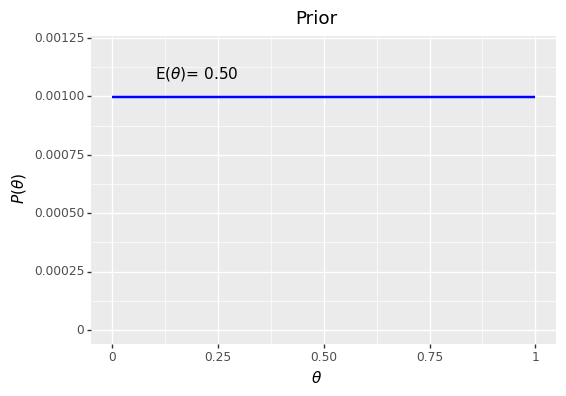

<ggplot: (-9223371911989045544)>


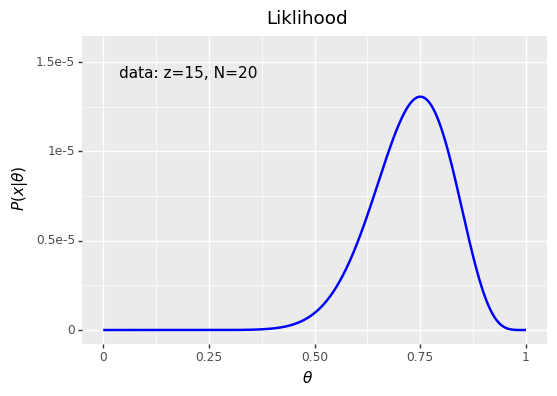

<ggplot: (-9223371911987642568)>


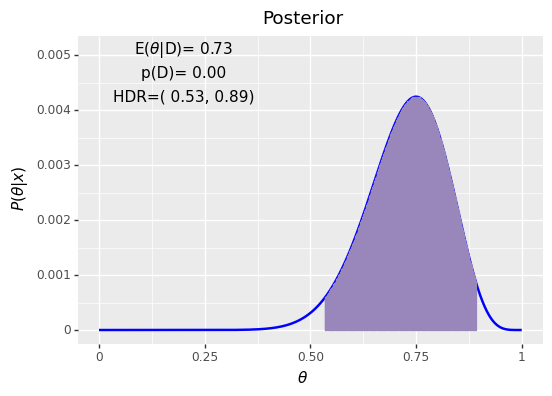

<ggplot: (-9223371911989007880)>


array([0.00000000e+00, 3.23959333e-43, 1.05624750e-38, ...,
       1.01104655e-11, 3.20734279e-13, 0.00000000e+00])

In [81]:
#Create vector of theta values.
bin_width = 1/1000.
theta_grid = np.arange(0, 1+bin_width, bin_width)

#Specify prior
rel_prob = np.array([0.1] * len(theta_grid))  # uniform prior
rel_prob = np.array([0.1] * len(theta_grid))  # uniform prior
prior = rel_prob / sum(rel_prob)  # probability mass at each theta

#data
data = np.array([0]*5 + [1]*15)

bern_grid(theta_grid, prior, data)

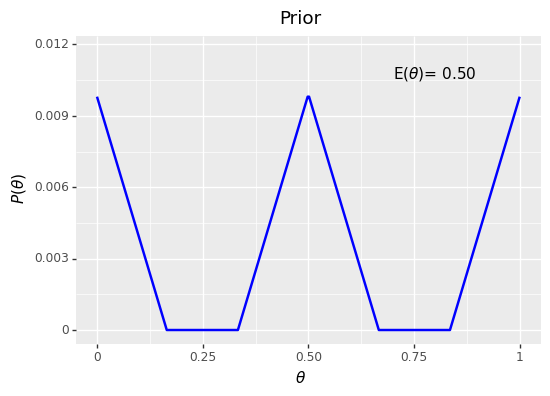

<ggplot: (-9223371911988992664)>


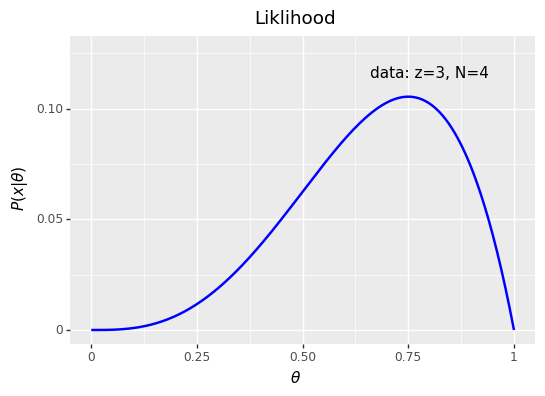

<ggplot: (-9223371911989553312)>


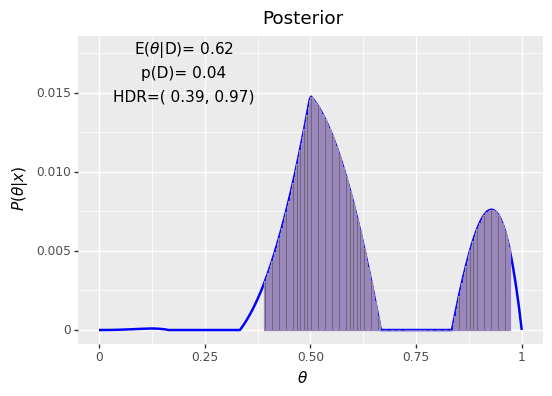

<ggplot: (-9223371911987694544)>


In [82]:
dataVector = list(reversed(range(51))) + \
            [0]*50 + \
            list(range(51)) + \
            list(reversed(range(51))) + \
            [0]*50 + \
            list((range(51)))
            
# convert to probability dist
pTheta = dataVector / np.sum(dataVector)
theta_grid = np.linspace(0,1, len(pTheta))
#data
data = np.array([0]*1 + [1]*3)

p_theta_given_data = bern_grid(theta_grid, pTheta, data)

In [ ]:
import pystan
import arviz as av

In [64]:
code = """
data {
    int N;       //#of coin tosses
    int y[N];    //#of heads
}
parameters {
    real<lower=0,upper=1> p;
}
model {
    //prior
    p ~ beta(0.3, 0.05);
    //liklihood
    y ~ bernoulli(p);
}
"""

In [79]:
data = {
    'N': 20,
    'y':  [1]* 5 + [0] * 15
}

In [80]:
model = pystan.StanModel(model_code=code);

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c40a435379c2d2606edb480da5755f9 NOW.


In [81]:
fit = model.sampling(data=data, iter=1000, warmup=500, chains=4)

In [82]:
results = fit.extract(permuted=True)  # return a dictionary of arrays

In [83]:
av.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p,0.260,0.095,0.094,0.440,0.002,0.002,1446.0,1387.0,1481.0,1716.0,NaN
lp__,-12.181,0.695,-13.500,-11.671,0.017,0.012,1744.0,1744.0,1767.0,1605.0,NaN


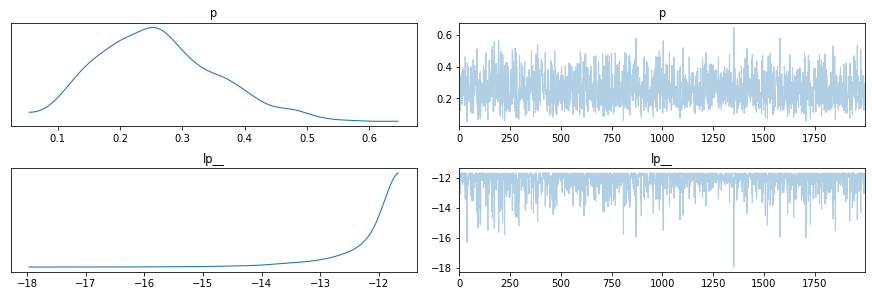

In [84]:
av.plot_trace(results);

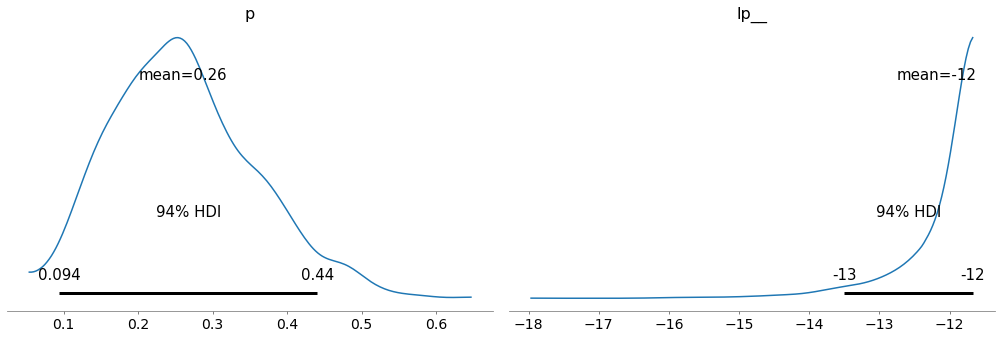

In [85]:
av.plot_posterior(results);

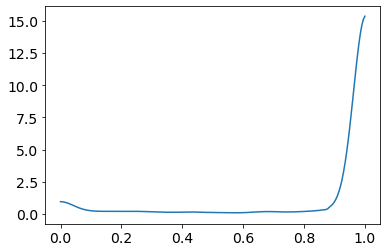

In [89]:
av.plot_dist(np.random.beta(0.3, 0.05, 1000));

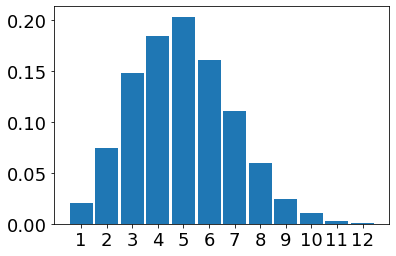

In [88]:
av.plot_dist(np.random.binomial(20, 5/20, 1000));